# **Deep learning for multiclass classification and diagnosis of Alzheimer's disease**

In [9]:
#Importing all the required libraries for the project
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
import tensorflow as tf
import pandas as pd
from random import randint
from tqdm.notebook import tqdm
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, MaxPool2D
import os
import cv2
sns.set()


In [6]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [24]:
#Dataset that should go with Alzheimer label
very_mild = glob('/content/drive/MyDrive/adni/Very_Mild_Demented/*')
mild = glob('/content/drive/MyDrive/adni/Mild_Demented/*')
moderate = glob('/content/drive/MyDrive/adni/Moderate_Demented/*')

#Dataset without Alzheimer
non = glob('/content/drive/MyDrive/adni/Non_Demented/*')

In [13]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/adni', output="output", seed=1345, ratio=(.8, 0.1,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6400 files [02:31, 42.26 files/s] 


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [19]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [20]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

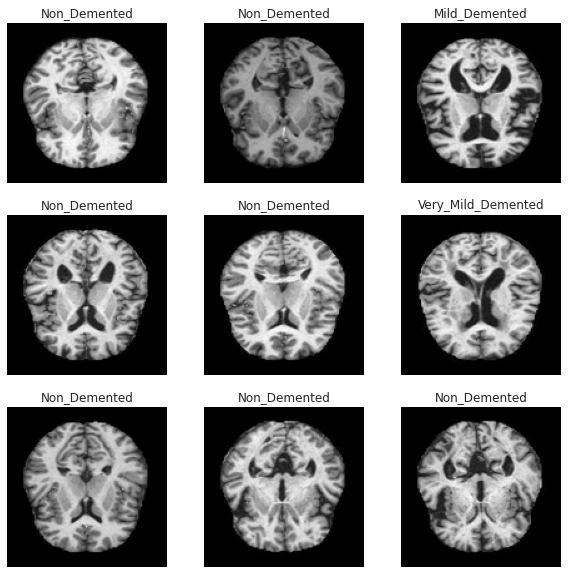

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(*args, **kw)>

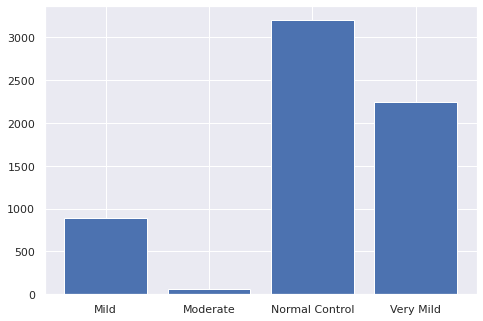

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
class_names2 = ['Mild', 'Moderate', 'Normal Control', 'Very Mild']
ax.bar(class_names2,size)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

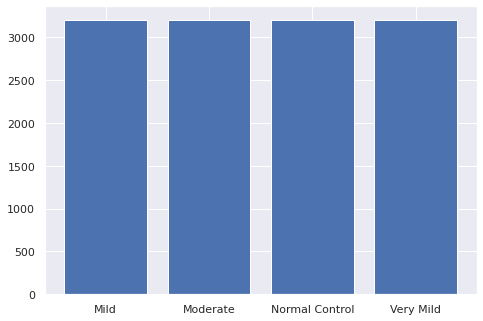

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [3200,3200,3200,3200]
class_names2 = ['Mild', 'Moderate', 'Normal Control', 'Very Mild']
ax.bar(class_names2,size)
plt.show

/content/drive/MyDrive/adni/Non_Demented/non_2934.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

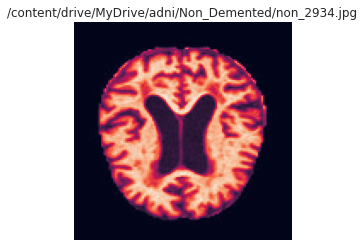

In [25]:
print(non[1])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non[1])

Alzheimer Patient's Brain
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

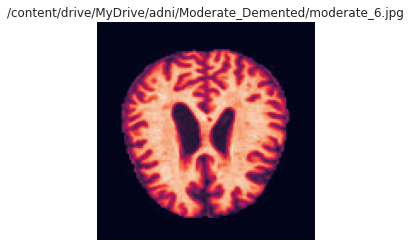

In [27]:
print('Alzheimer Patient\'s Brain')
view_image(moderate[1])

# Extracting Features and PCA

In [28]:
def extract_features(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  
    img = resize(img, (128, 128, 3)) 
    img = np.reshape(img, (128, 384))
    return img


In [29]:
non_ALZ = [extract_features(filename) for filename in non]
vmild_ALZ = [extract_features(filename) for filename in very_mild]
mild_ALZ = [extract_features(filename) for filename in mild]
moderate_ALZ = [extract_features(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

In [30]:
#for PCA
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
#print(all_data)
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))


In [31]:
scaler = StandardScaler()
scaler.fit(all_data)

StandardScaler()

In [32]:
#standardize data to 0 mean and unit variance
X = scaler.transform(all_data)

In [ ]:
#split the data 
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

In [ ]:
scala = preprocessing.StandardScaler()
pca = decomposition.PCA(200)
X_proj = pca.fit_transform(X_train)

In [ ]:
# Getting the cumulative variance 
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

In [ ]:
# Principal Components having 80% of the variance
k = np.argmax(var_cumu>80)
print("Principal Components having 80% variance: "+ str(k))

Principal Components having 80% variance: 174


[[ 12.39494591  14.50452203  32.84173782 ...  -0.39460968  -0.64782319
   -0.1452399 ]
 [ 24.00593839  -5.442134     3.93136175 ...  -1.74603721  -0.09724987
   -0.18783322]
 [-17.01512939  -4.34023051   6.35960616 ...   0.41690896   0.42935859
   -0.59382766]
 ...
 [  9.09882132  25.19850478  31.17391061 ...  -0.45739437  -0.4120038
    1.24712262]
 [  5.74884255  15.11808538  -7.90622447 ...   0.13495746  -0.80129671
   -0.61623126]
 [ 20.83495301 -17.80444377   9.61878681 ...  -0.19112565   0.81218804
    0.68652986]]


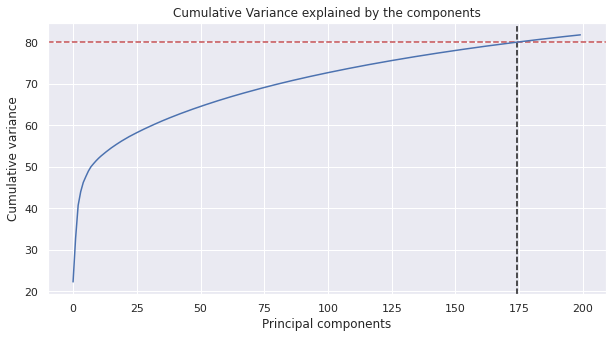

In [ ]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Variance explained by the components')
plt.ylabel('Cumulative variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=80, color="r", linestyle="--")
ax = plt.plot(var_cumu)

print(X_proj)

## Implementing Linear Discriminant Analysis for the detection of Alzheimer's disease

In [ ]:
#Model implementation
lda = LDA(n_components=1)
X_train_LDA = lda.fit_transform(X_train, y_train)
X_test_LDA = lda.transform(X_test)

In [ ]:
#Accuracy for test and train data
accuracy_test = lda.score(X_test, y_test)
print("Accuracy for Testing Data: {:0.2f}%".format(accuracy_test*100))
accuracy_train = lda.score(X_train, y_train)
print("Accuracy for Training Data: {:0.2f}%".format(accuracy_train*100))

Accuracy for Testing Data: 90.00%
Accuracy for Training Data: 99.96%


In [52]:
#Resizing images for SVM Model
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting. 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)

In [53]:
print(len(non))
print(len(ALZ)) #data are well transformed. Let's conduct SVM
print(len(resized_image_array))
print(resized_image_array[1])

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

3200
3200
6400
[0 0 0 ... 0 0 0]


# Implementing Support Vector Machine for the detection of Alzheimer's disease

In [89]:
#Support Vector Machine Linear Model
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)

SVC(kernel='linear')

In [90]:
#Performance metrics of the SVM with linear kernel on Training and Testing data

y_train_pred = clf.predict(train_x)
y_true = train_y
print('Accuracy : ', metrics.accuracy_score(y_true, y_train_pred))
print('Precision : ', metrics.precision_score(y_true, y_train_pred, average='micro'))
print('Recall : ', metrics.recall_score(y_true, y_train_pred, average='micro'))
print('F1-score : ', metrics.f1_score(y_true, y_train_pred, average = 'micro')) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_train_pred)) 

Accuracy :  1.0
Precision :  1.0
Recall :  1.0
F1-score :  1.0
Confusion matrix : [[2552    0]
 [   0 2568]]


In [91]:
y_pred = clf.predict(test_x)
y_true = test_y
print("Accuracy : {:0.2f}%".format(metrics.accuracy_score(y_true, y_pred)*100))
print("Precision : {:0.2f}%".format(metrics.precision_score(y_true, y_pred, average='micro')*100))
print("Recall : {:0.2f}%".format(metrics.recall_score(y_true, y_pred, average='micro')*100))
print("F1-score : {:0.2f}%".format(metrics.f1_score(y_true, y_pred, average='micro')*100))
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred)) 

Accuracy : 98.36%
Precision : 98.36%
Recall : 98.36%
F1-score : 98.36%
Confusion matrix : [[636  12]
 [  9 623]]


In [38]:
accuracy_score(y_pred,test_y)
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       664
           1       0.98      0.99      0.98       616

    accuracy                           0.98      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280



In [40]:
Class = ['AD', 'CN']

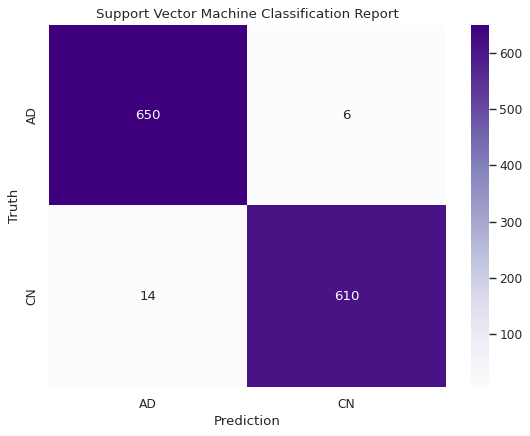

In [43]:
conf_arr = metrics.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels= Class,
                yticklabels=Class)

plt.title('Support Vector Machine Classification Report')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

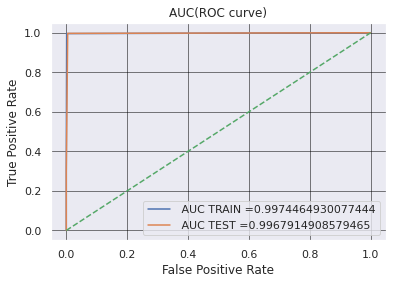

In [66]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(train_y, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(test_y, y_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# SVM using RBF kernal

In [ ]:
#Train a SVM using RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

Accuracy :  0.8681640625
Precision :  0.8552882779686903
Recall :  0.8832807570977917
f1 :  0.8690591658583898
Confusion matrix : [[2205  379]
 [ 296 2240]]
Accuracy :  0.83359375
Precision :  0.8253968253968254
Recall :  0.8614457831325302
f1 :  0.843036109064112
Confusion matrix : [[495 121]
 [ 92 572]]


# Support Vector Machine for Classification of Alzheimer's disease

In [44]:
resized_image_array=[]
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) 

#Iterating over images and resizing them to 256*256
def resizer(image_directory):
    for file in image_directory: 
        img = Image.open(file)  
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        elif image_directory == very_mild:
            resized_image_array_label.append(1)
        elif image_directory == mild:
            resized_image_array_label.append(2)
        else:
            resized_image_array_label.append(3)

resizer(non)
resizer(very_mild)
resizer(mild)
resizer(moderate)

In [45]:
#Splitting the data for testing, training and validation
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

In [46]:
#Training the SVM model for classification
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)

SVC(kernel='linear')

In [47]:
y_pred = clf.predict(train_x)
y_true = train_y
y_pred = clf.predict(test_x)
y_true = test_y

In [48]:
#Accuracy for testing and training data

print('Training Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print("Testing Accuracy : {:0.2f}%".format(metrics.accuracy_score(y_true, y_pred)*100))

Training Accuracy :  0.98359375
Testing Accuracy : 98.36%


In [50]:
accuracy_score(y_pred,test_y)
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       639
           1       0.97      0.98      0.98       443
           2       0.98      1.00      0.99       183
           3       1.00      1.00      1.00        15

    accuracy                           0.98      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.98      0.98      0.98      1280



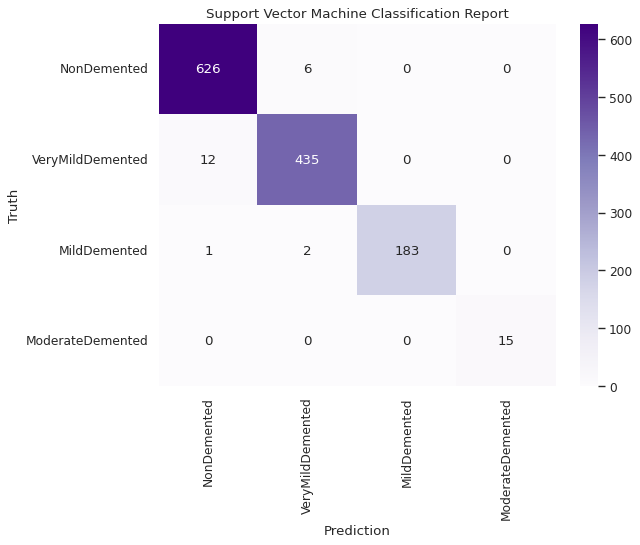

In [51]:
conf_arr = metrics.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Support Vector Machine Classification Report')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

# Implementation of Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()

In [55]:
model.fit(train_x,train_y)

RandomForestClassifier()

In [56]:
y_pred=model.predict(test_x)
y_pred
y_true = test_y
print("Accuracy : {:0.2f}%".format(metrics.accuracy_score(y_true, y_pred)*100))

Accuracy : 93.83%


In [61]:
y_train_pred=model.predict(train_x)
y_train_pred
y_true_train = train_y
print("Accuracy : {:0.2f}%".format(metrics.accuracy_score(y_true_train, y_train_pred)*100))

Accuracy : 100.00%


In [57]:
accuracy_score(y_pred,test_y)
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       647
           1       0.94      0.94      0.94       633

    accuracy                           0.94      1280
   macro avg       0.94      0.94      0.94      1280
weighted avg       0.94      0.94      0.94      1280



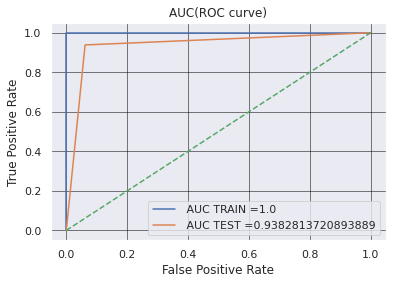

In [63]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(train_y, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(test_y, y_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

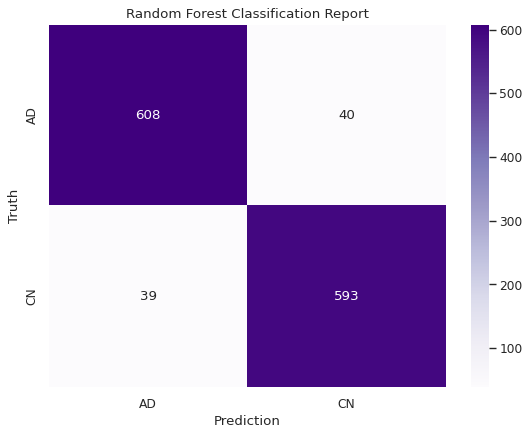

In [58]:
conf_arr = metrics.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels= Class,
                yticklabels=Class)

plt.title('Random Forest Classification Report')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

# Implementation of EfficientNetB0 for classification of Alzheimer's diseae without SMOTE

In [ ]:
data = '/content/drive/MyDrive/adni/'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    color_mode='grayscale',
    image_size=(128,128),
    batch_size=32,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split= 0.2,
    subset="validation",
    seed=42,
    color_mode= 'grayscale',
    image_size = (128,128),
    batch_size=32,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [ ]:
class_name = test_data.class_names
class_name

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


40/40 [==============================] - 6s 148ms/step - loss: 0.1717 - accuracy: 0.9563


[0.1717132180929184, 0.956250011920929]

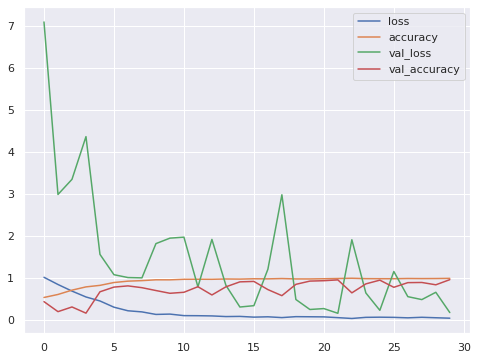

In [ ]:


#Model Changing the learning rate
EffNet = tf.keras.applications.EfficientNetB0(include_top = False)
EffNet.trainable = True
inputs = tf.keras.layers.Input(shape=((128,128) + (1,)), name = 'input_layer')
x = EffNet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
Learning_Rate = 0.01
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = Learning_Rate), metrics=['accuracy'])
model.summary()

#Training the Model
graphs = model.fit(train_data, validation_data = test_data, epochs = 30, verbose = False)
pd.DataFrame(graphs.history).plot(figsize=(8,6))

#check the performance
model.evaluate(test_data)

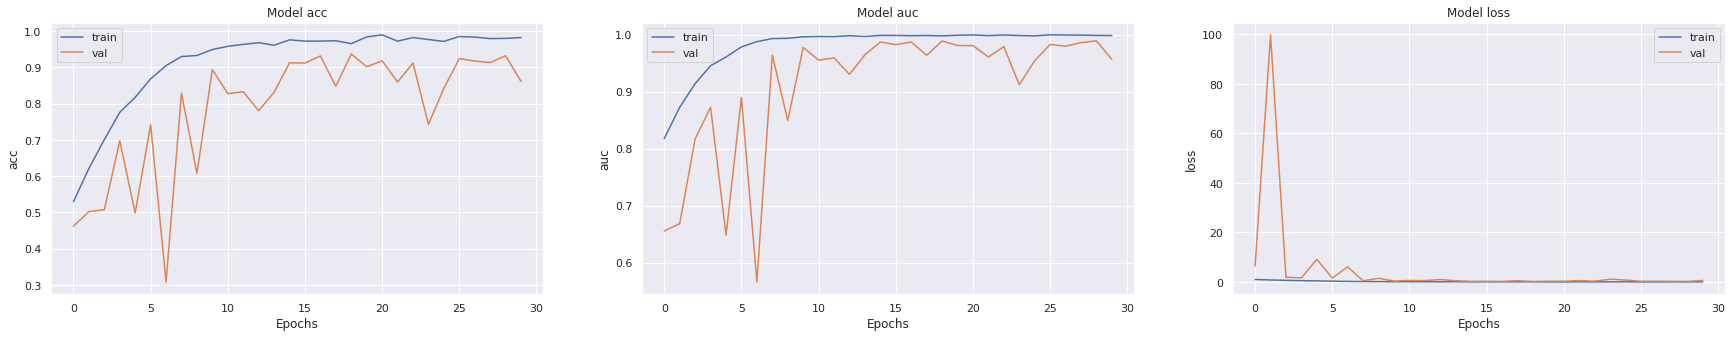

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(graphs.history[metric])
    ax[i].plot(graphs.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
pred_labels = model.predict(test_data)

In [ ]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(pred_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       1.00      1.00      1.00       174
VeryMildDemented       1.00      1.00      1.00        15
    MildDemented       1.00      1.00      1.00       606
ModerateDemented       1.00      1.00      1.00       485

       micro avg       1.00      1.00      1.00      1280
       macro avg       1.00      1.00      1.00      1280
    weighted avg       1.00      1.00      1.00      1280
     samples avg       1.00      1.00      1.00      1280



# Implementing Inception-V3 for the classification of Alzheimer's disease

In [69]:
base_dir = "/content/drive/MyDrive/adni/"

In [70]:
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [71]:
# ZOOM operation
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=base_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [72]:
train_data, train_labels = train_data_gen.next()

In [73]:
#Performing over-sampling of the data, for image augmentation
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [74]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [106]:

test_data.shape

(2560, 176, 176, 3)

In [113]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 0s 0us/step


In [114]:
for layer in inception_model.layers:
    layer.trainable=False

In [115]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [116]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [117]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_101 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 512)       

In [118]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50
history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 83s 298ms/step - loss: 1.3443 - acc: 0.4199 - auc: 0.6935 - f1_score: 0.4158 - val_loss: 0.8359 - val_acc: 0.5903 - val_auc: 0.8680 - val_f1_score: 0.5807 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 85s 331ms/step - loss: 0.9146 - acc: 0.5741 - auc: 0.8463 - f1_score: 0.5675 - val_loss: 0.6901 - val_acc: 0.6655 - val_auc: 0.9085 - val_f1_score: 0.6526 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 87s 340ms/step - loss: 0.7967 - acc: 0.6353 - auc: 0.8830 - f1_score: 0.6277 - val_loss: 0.6372 - val_acc: 0.6865 - val_auc: 0.9216 - val_f1_score: 0.6745 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 87s 340ms/step - loss: 0.7339 - acc: 0.6652 - auc: 0.9015 - f1_score: 0.6621 - val_loss: 0.5989 - val_acc: 0.7168 - val_auc: 0.9317 - val_f1_score: 0.7090 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 86s 336ms/step - loss: 0.6767 - acc: 0.6926 - auc: 0.9162 

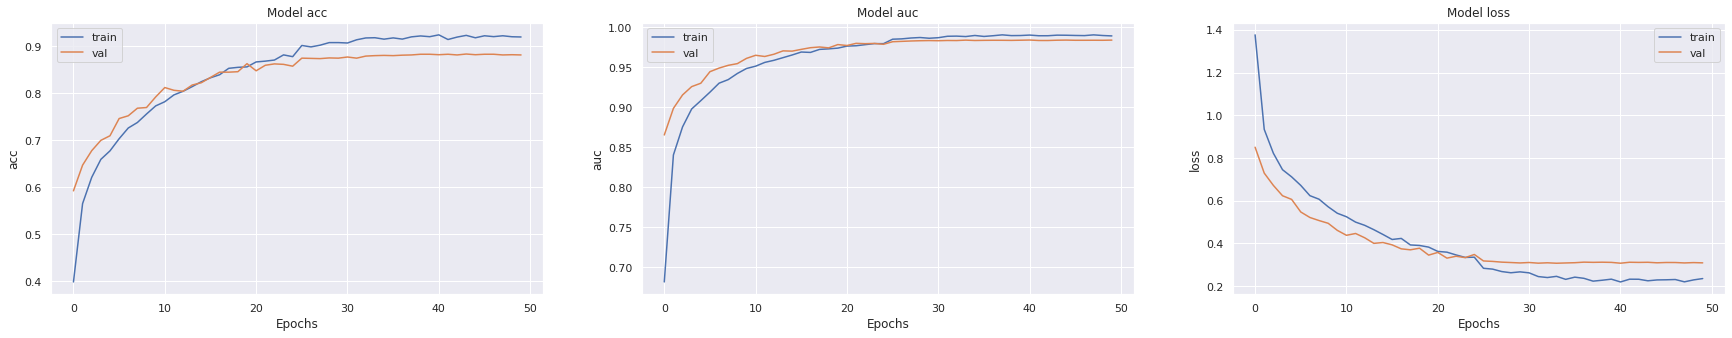

In [22]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [119]:
pred_labels = custom_inception_model.predict(test_data)

In [23]:
pred_labels = custom_inception_model.predict(test_data)

In [24]:
train_scores = custom_inception_model.evaluate(train_data, train_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 13s 159ms/step - loss: 0.3219 - acc: 0.8828 - auc: 0.9820 - f1_score: 0.8827
Training Accuracy: 99.26%
Testing Accuracy: 88.28%


In [27]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.90      0.94      0.92       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.86      0.78      0.82       662
ModerateDemented       0.77      0.82      0.79       624

       micro avg       0.88      0.88      0.88      2560
       macro avg       0.88      0.88      0.88      2560
    weighted avg       0.88      0.88      0.88      2560
     samples avg       0.88      0.88      0.88      2560



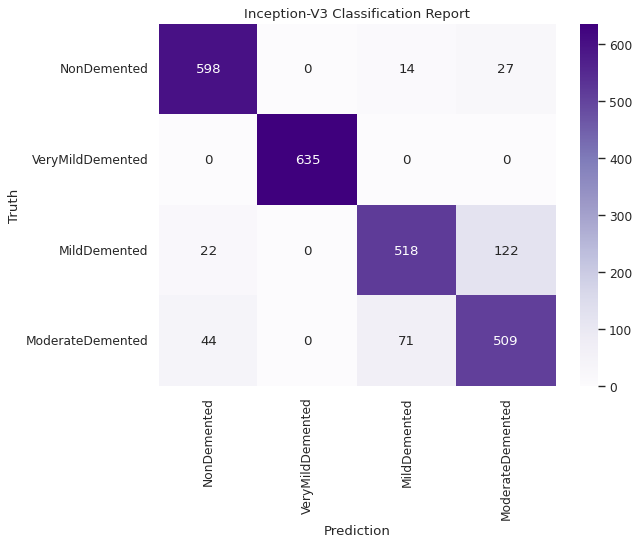

In [28]:

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Inception-V3 Classification Report')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [29]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 88.35 %
Matthew's Correlation Coefficient: 84.42 %


In [84]:
import pathlib 
data_dir2 = pathlib.Path(base_dir)

In [85]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory

t_data = image_dataset_from_directory(
                  data_dir2,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(176, 176),
                  batch_size=32)


val_data2 = image_dataset_from_directory(data_dir2,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(176,176),
                                        batch_size=32)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [30]:
FP = conf_arr.sum(axis=0) - np.diag(conf_arr) 
FN = conf_arr.sum(axis=1) - np.diag(conf_arr)
TP = np.diag(conf_arr)
TN = conf_arr.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
print('False Positive:', FP)
print('False Negative:', FN)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('Precision:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('Negativ Predictive value:', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False Positive Rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False Negative Rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('False discovery rate:', FDR)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy', ACC)

False Positive: [ 66.   0.  85. 149.]
False Negative: [ 41.   0. 144. 115.]
Sensitivity: [0.93583725 1.         0.78247734 0.81570513]
Specificity: [0.96564289 1.         0.95521602 0.92303719]
Precision: [0.90060241 1.         0.85903814 0.77355623]
Negativ Predictive value: [0.97837553 1.         0.92641799 0.93953733]
False Positive Rate: [0.03435711 0.         0.04478398 0.07696281]
False Negative Rate: [0.06416275 0.         0.21752266 0.18429487]
False discovery rate: [0.09939759 0.         0.14096186 0.22644377]
Accuracy [0.95820313 1.         0.91054687 0.896875  ]


In [34]:
!pip install torchvision 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import torch
import torchvision
model_save_name = 'inception.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(custom_inception_model, path)

ROC AUC score: 0.9263565482420837


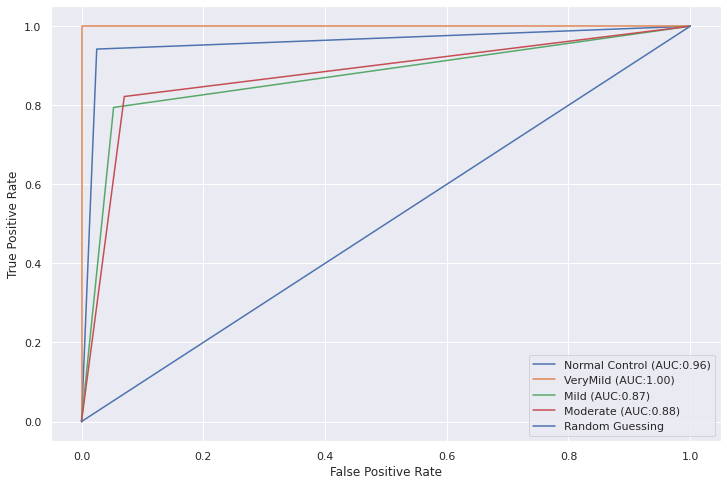

In [120]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
ypredc = pred_labels.argmax(axis=-1)
trainc = test_labels.argmax(axis=-1)
ypredc

target= ['Normal Control', 'VeryMild', 'Mild', 'Moderate']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(trainc, ypredc))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


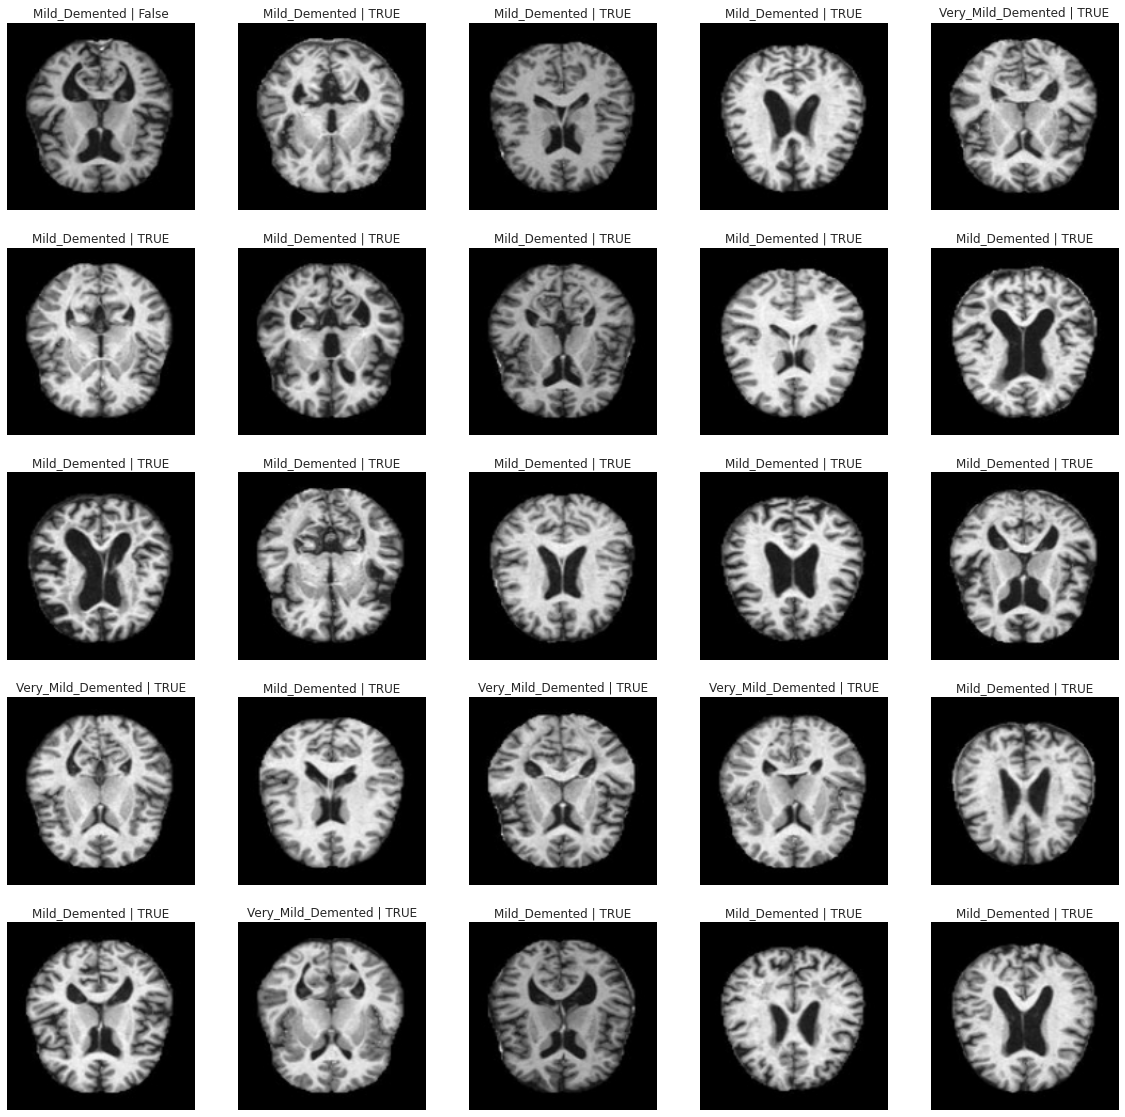

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(20, 20))
class_names = val_data2.class_names
result = ' | False'
for images, labels in val_data2.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = custom_inception_model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

# AlzhiNet implementation for the classification of Alzheimer's disease



In [1]:
#Setting the convolutional block
def conv_block(filters, act='relu'):
  
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [2]:
# Setting the dense layer block
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [3]:
# Constructing the model
def construct_model(act='relu'):
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [67]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [75]:

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

In [76]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 149s 573ms/step - loss: 1.6545 - acc: 0.2825 - auc: 0.5425 - f1_score: 0.2822 - val_loss: 1.7693 - val_acc: 0.2568 - val_auc: 0.5375 - val_f1_score: 0.1275
Epoch 2/50
256/256 [==============================] - 148s 579ms/step - loss: 1.2377 - acc: 0.4229 - auc: 0.7114 - f1_score: 0.4133 - val_loss: 4.9453 - val_acc: 0.2422 - val_auc: 0.5002 - val_f1_score: 0.0990
Epoch 3/50
256/256 [==============================] - 147s 576ms/step - loss: 0.9391 - acc: 0.5704 - auc: 0.8398 - f1_score: 0.5615 - val_loss: 0.8732 - val_acc: 0.5933 - val_auc: 0.8625 - val_f1_score: 0.5737
Epoch 4/50
256/256 [==============================] - 148s 579ms/step - loss: 0.7750 - acc: 0.6420 - auc: 0.8897 - f1_score: 0.6325 - val_loss: 2.3964 - val_acc: 0.4609 - val_auc: 0.7138 - val_f1_score: 0.3348
Epoch 5/50
256/256 [==============================] - 149s 582ms/step - loss: 0.7067 - acc: 0.6670 - auc: 0.9062 - f1_score: 0.6615 - val_loss: 2.9917 - val_acc

In [86]:
import torch
import torchvision
model_save_name = 'alzhinet.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model, path)

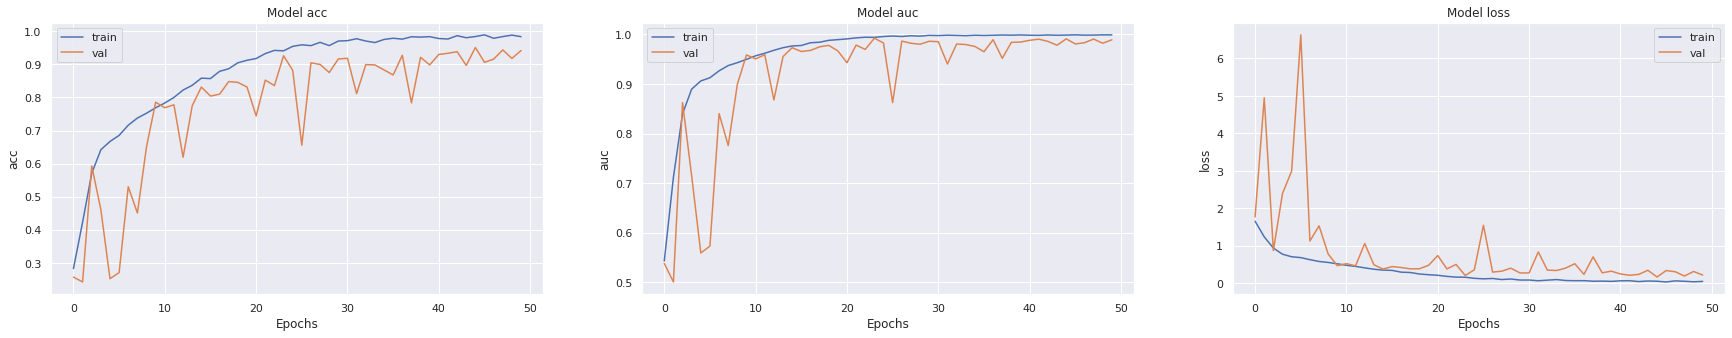

In [77]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [78]:
train_scores = model.evaluate(train_data, train_labels)
test_scores =model.evaluate(test_data, test_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 6s 74ms/step - loss: 0.2328 - acc: 0.9406 - auc: 0.9876 - f1_score: 0.9408
Training Accuracy: 99.50%
Testing Accuracy: 94.06%


In [79]:
#Predicting the test data
pred_labels = model.predict(test_data)

In [88]:
pred_train_labels = model.predict(train_data)

In [80]:
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       1.00      0.95      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.87      0.95      0.91       662
ModerateDemented       0.90      0.86      0.88       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



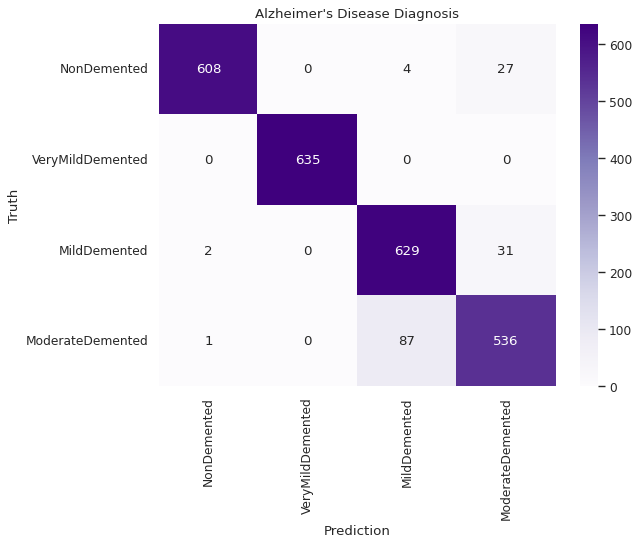

In [81]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)
conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [82]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 94.02 %
Matthew's Correlation Coefficient: 92.13 %


In [95]:
train_labels.shape
y_train = tf.keras.utils.to_categorical(train_labels , num_classes=4)
y_train.shape

(8192, 4, 4)

In [107]:
ypredc = pred_labels.argmax(axis=-1)
trainc = test_labels.argmax(axis=-1)
ypredc

array([3, 1, 2, ..., 1, 2, 0])

ROC AUC score: 0.9601433180693487


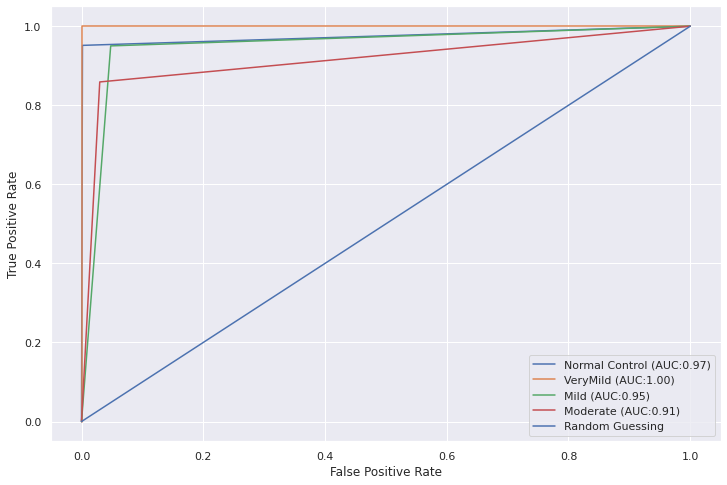

In [109]:
# ROC and AUC curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Normal Control', 'VeryMild', 'Mild', 'Moderate']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(trainc, ypredc))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


In [83]:
#Calculating all the perfomance metrics
FP = conf_arr.sum(axis=0) - np.diag(conf_arr) 
FN = conf_arr.sum(axis=1) - np.diag(conf_arr)
TP = np.diag(conf_arr)
TN = conf_arr.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
print('False Positive:', FP)
print('False Negative:', FN)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('Precision:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('Negativ Predictive value:', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False Positive Rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False Negative Rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('False discovery rate:', FDR)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy', ACC)

False Positive: [ 3.  0. 91. 58.]
False Negative: [31.  0. 33. 88.]
Sensitivity: [0.9514867  1.         0.95015106 0.85897436]
Specificity: [0.99843831 1.         0.95205479 0.97004132]
Precision: [0.99509002 1.         0.87361111 0.9023569 ]
Negativ Predictive value: [0.98409441 1.         0.98206522 0.95523906]
False Positive Rate: [0.00156169 0.         0.04794521 0.02995868]
False Negative Rate: [0.0485133  0.         0.04984894 0.14102564]
False discovery rate: [0.00490998 0.         0.12638889 0.0976431 ]
Accuracy [0.98671875 1.         0.9515625  0.94296875]


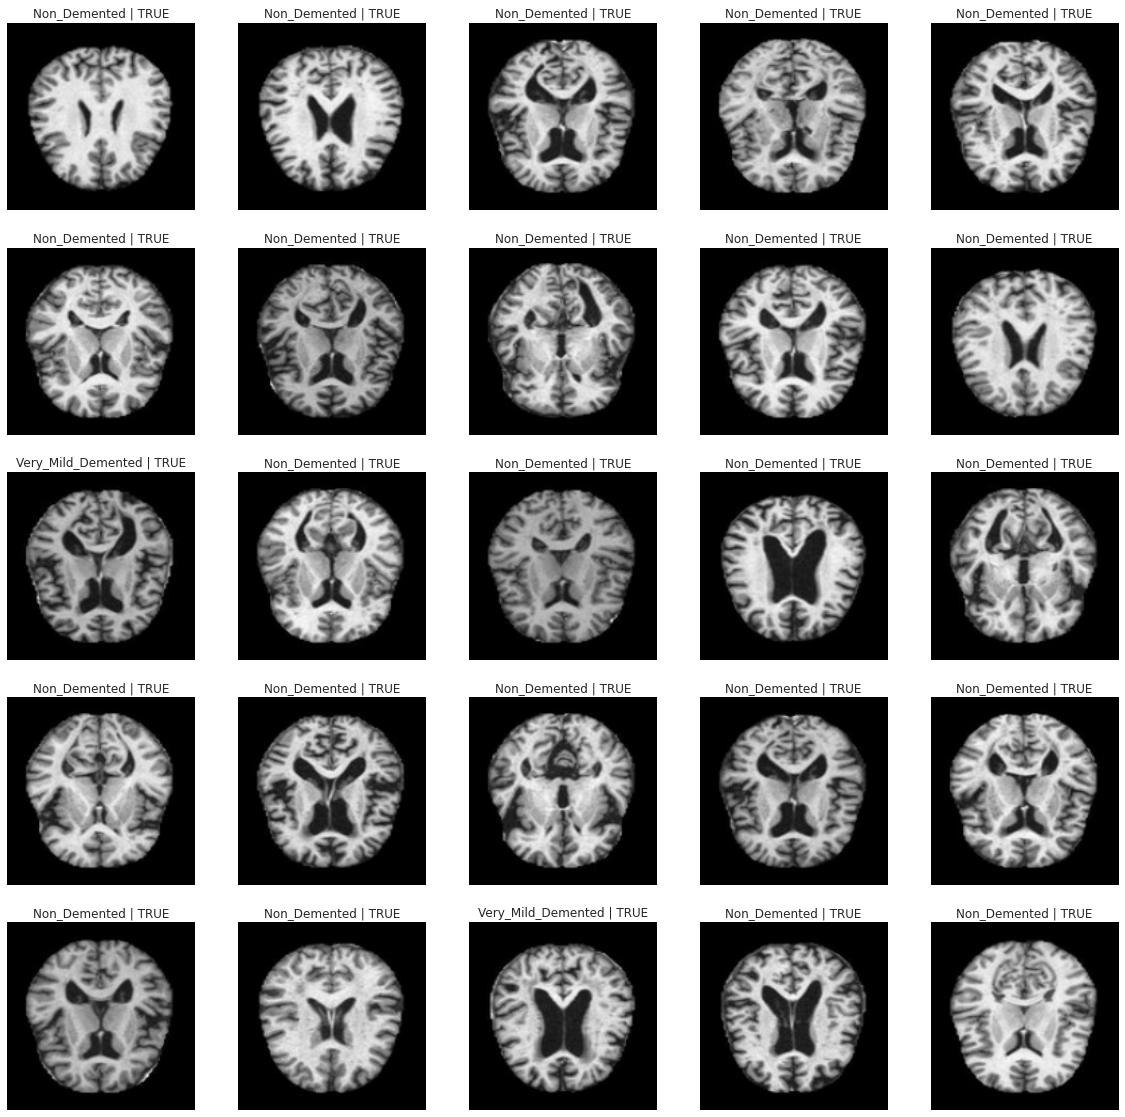

In [87]:
#Testing on the test data
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(20, 20))
class_names = val_data2.class_names
result = ' | False'
for images, labels in val_data2.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

# Efficient Net Implementation with SMOTE

In [ ]:
IMG_SIZE2 = 128
IMAGE_SIZE2 = [128, 128]
DIM2 = (IMG_SIZE2, IMG_SIZE2)

In [ ]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=base_dir, target_size=DIM2, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [ ]:
train_data, train_labels = train_data_gen.next()

In [ ]:
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE2 * IMG_SIZE2 * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE2, IMG_SIZE2, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
inputs = tf.keras.layers.Input(shape=(128,128,1), name="input_layer")
# Efficient net model has the normalizing layer builtin
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(CLASSES), activation="softmax", name="output_layer")(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# Epochs
EPOCHS = 50
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
CALLBACKS = [my_callback, rop_callback]
# Default Learning rate
LR = 0.001
model.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=METRICS)
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50


256/256 [==============================] - ETA: 0s - loss: 0.1060 - acc: 0.9630 - auc: 0.9969 - f1_score: 0.9630

256/256 [==============================] - 184s 687ms/step - loss: 0.1060 - acc: 0.9630 - auc: 0.9969 - f1_score: 0.9630 - val_loss: 6.3214 - val_acc: 0.2422 - val_auc: 0.5034 - val_f1_score: 0.0975 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 149s 581ms/step - loss: 0.0783 - acc: 0.9728 - auc: 0.9982 - f1_score: 0.9728 - val_loss: 4.3157 - val_acc: 0.2422 - val_auc: 0.5009 - val_f1_score: 0.0975 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 150s 586ms/step - loss: 0.0589 - acc: 0.9785 - auc: 0.9990 - f1_score: 0.9785 - val_loss: 4.2773 - val_acc: 0.2422 - val_auc: 0.4989 - val_f1_score: 0.0975 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 148s 579ms/step - loss: 0.0667 - acc: 0.9767 - auc: 0.9988 - f1_score: 0.9767 - val_loss: 2.6113 - val_acc: 0.2422 - val_auc: 0.5143 - val_f1_score: 0.0975 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 149s 583ms/step - loss: 0.0537 - acc: 0.9799 - auc: 0.9989 - f1_s

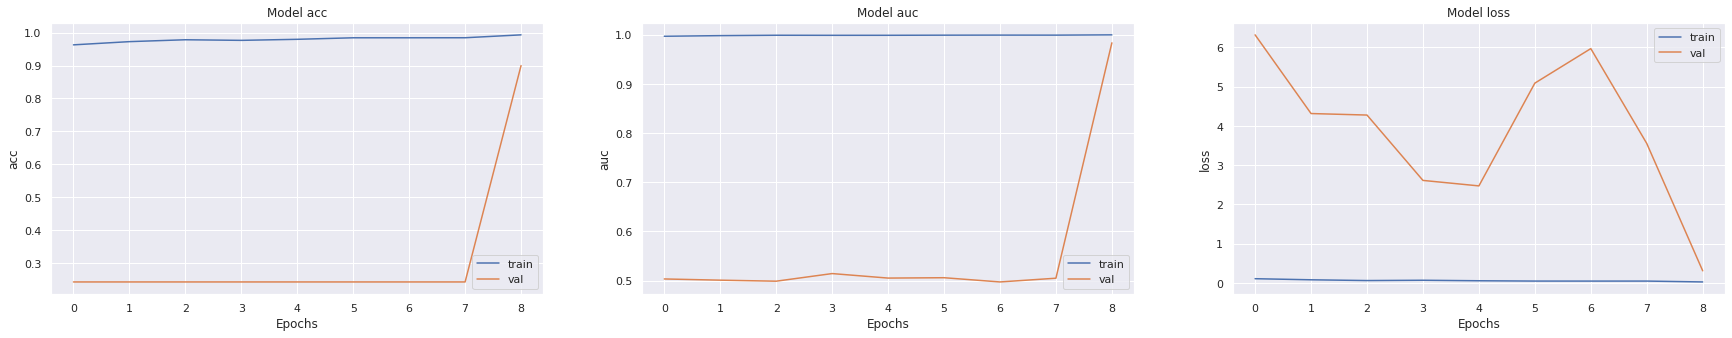

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
train_scores = model.evaluate(train_data, train_labels)
test_scores =model.evaluate(test_data, test_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 9s 108ms/step - loss: 0.3176 - acc: 0.8910 - auc: 0.9831 - f1_score: 0.8886
Training Accuracy: 94.56%
Testing Accuracy: 89.10%


In [ ]:
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
#Predicting the test data
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.97      0.96       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.98      0.63      0.77       662
ModerateDemented       0.72      0.97      0.83       624

       micro avg       0.89      0.89      0.89      2560
       macro avg       0.91      0.89      0.89      2560
    weighted avg       0.91      0.89      0.89      2560
     samples avg       0.89      0.89      0.89      2560



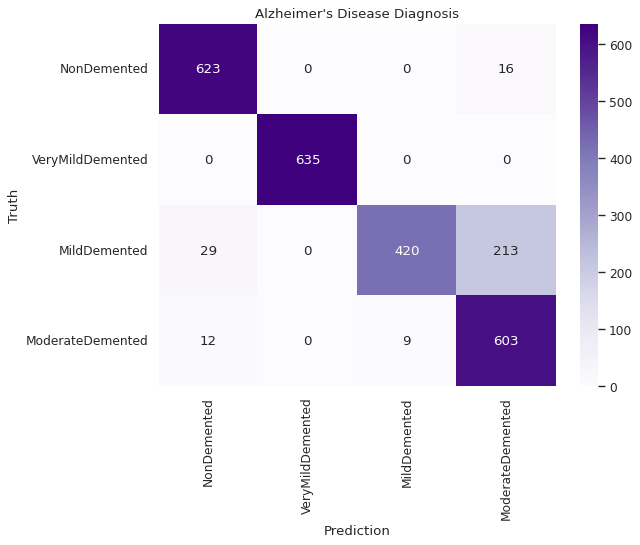

In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Purples', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
# Compute ROC curve and ROC area for each class
results = model.evaluate(test_data, test_labels)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

80/80 [==============================] - 9s 108ms/step - loss: 0.3176 - acc: 0.8910 - auc: 0.9831 - f1_score: 0.8886
loss :  0.3175632357597351
acc :  0.8910156488418579
auc :  0.9831275343894958
f1_score :  [0.9562548  1.         0.76993585 0.8282967 ]


In [ ]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 89.39 %
Matthew's Correlation Coefficient: 86.36 %
Balanced Accuracy Score: 89.39 %
Matthew's Correlation Coefficient: 86.36 %
